# Stock Portfolio Optimizer

This notebook implements a comprehensive stock portfolio optimization tool using Modern Portfolio Theory (MPT), Mean-Variance Optimization (MVO), and Monte Carlo simulations.

## Table of Contents
1. [Setup and Imports](#setup)
2. [Data Collection](#data)
3. [Data Preprocessing](#preprocessing)
4. [Risk & Return Calculations](#calculations)
5. [Portfolio Optimization](#optimization)
6. [Monte Carlo Simulation](#simulation)
7. [Visualization](#visualization)
8. [Results Analysis](#results)

<a id='setup'></a>
## 1. Setup and Imports

In [11]:
# Import required libraries
import numpy as np
import pandas as pd
import yfinance as yf
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.cluster import KMeans

# Set plotting style
sns.set_style('whitegrid')

# Configure pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)

# Set random seed
np.random.seed(42) 

<a id='data'></a>
## 2. Data Collection and Preprocessing

First, we'll define our stock universe and fetch historical data.

In [12]:
# Define stock tickers by sector
tickers = {
    'Technology': ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'NVDA', 'AMD', 'INTC', 'QCOM', 'IBM'],
    'Energy': ['XOM', 'CVX', 'COP', 'SLB', 'BP'],
    'Financials': ['JPM', 'BAC', 'WFC', 'C', 'GS'],
    'Healthcare': ['JNJ', 'PFE', 'MRK', 'ABBV', 'TMO'],
    'Consumer': ['TSLA', 'HD', 'NKE', 'SBUX', 'MCD']
}

# Flatten tickers list
all_tickers = [ticker for sector in tickers.values() for ticker in sector]

# Set date range
start_date = '2014-01-01'
end_date = datetime.now().strftime('%Y-%m-%d')

# Fetch historical data
def get_stock_data(tickers, start, end):
    """Fetch historical stock data for given tickers."""
    data = yf.download(tickers, start=start, end=end)
    if isinstance(data.columns, pd.MultiIndex):
        data = data['Close']
    else:
        data = data[['Close']]
    return data

# Get stock data
stock_data = get_stock_data(all_tickers, start_date, end_date)
print('Data shape:', stock_data.shape)
stock_data.head()

[*********************100%***********************]  30 of 30 completed

Data shape: (2819, 30)


Ticker,AAPL,ABBV,AMD,AMZN,BAC,BP,C,COP,CVX,GOOGL,GS,HD,IBM,INTC,JNJ,JPM,MCD,META,MRK,MSFT,NKE,NVDA,PFE,QCOM,SBUX,SLB,TMO,TSLA,WFC,XOM
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-01-02,17.2154,32.9803,3.95,19.8985,12.8956,24.9743,39.7036,48.3176,77.3605,27.7233,142.5944,63.1680,111.7598,19.1788,66.6776,43.0630,71.8542,54.4534,33.4898,30.9964,34.2775,0.3739,18.5162,53.3931,31.1288,65.7161,105.8099,10.0067,32.6956,62.1832
2014-01-03,16.8372,33.1833,4.00,19.8220,13.1439,24.9171,40.5619,48.4422,77.4914,27.5211,143.6102,63.0678,112.4284,19.1714,67.2783,43.3959,71.9510,54.3041,33.6522,30.7879,34.1855,0.3695,18.5526,53.0799,31.0401,65.3683,106.2153,9.9707,32.9280,62.0336
2014-01-06,16.9290,31.9715,4.13,19.6815,13.3441,24.9847,40.8733,48.6499,77.2857,27.8279,144.5936,62.4594,112.0429,18.9334,67.6299,43.6474,71.4368,56.9317,33.6590,30.1373,33.9227,0.3744,18.5709,52.9416,30.7255,65.1242,106.2249,9.8000,32.9861,62.1271
2014-01-07,16.8080,32.0349,4.18,19.9015,13.2160,25.2710,41.1544,48.7261,77.9400,28.3644,143.7230,62.7674,114.2777,19.0301,69.0655,43.1443,71.8318,57.6483,33.9094,30.3708,33.9490,0.3805,18.6864,53.3348,31.1450,64.7468,108.3966,9.9573,32.9716,63.0061
2014-01-08,16.9144,31.9524,4.18,20.0960,13.2800,25.3647,41.6329,48.2553,76.8308,28.4234,143.8440,63.0986,113.2295,18.9111,68.9703,43.5512,71.1088,57.9568,33.6928,29.8286,33.7737,0.3857,18.8140,53.6552,31.4757,64.3547,110.0663,10.0853,33.3492,62.8004


<a id='preprocessing'></a>
## 3. Risk & Return Calculations

Calculate daily returns, annualized returns, and annualized volitility.

In [13]:
# Calculate daily returns
daily_returns = stock_data.pct_change().dropna()

# Calculate annualized metrics
annual_expected_returns = daily_returns.mean() * 252
volatility = daily_returns.std() * np.sqrt(252)

print('Expected Annual Returns:\n', annual_expected_returns.round(4))
print('\nAnnualized Volatility:\n', volatility.round(4))

Expected Annual Returns:
 Ticker
AAPL     0.2640
ABBV     0.2024
AMD      0.4515
AMZN     0.2564
BAC      0.1507
BP       0.0748
C        0.1019
COP      0.1343
CVX      0.1067
GOOGL    0.1962
GS       0.1603
HD       0.1815
IBM      0.0988
INTC     0.0913
JNJ      0.0965
JPM      0.1871
MCD      0.1486
META     0.2820
MRK      0.1162
MSFT     0.2601
NKE      0.1105
NVDA     0.6249
PFE      0.0569
QCOM     0.1591
SBUX     0.1401
SLB      0.0308
TMO      0.1722
TSLA     0.4386
WFC      0.1152
XOM      0.0901
dtype: float64

Annualized Volatility:
 Ticker
AAPL     0.2794
ABBV     0.2640
AMD      0.5703
AMZN     0.3265
BAC      0.3030
BP       0.3050
C        0.3188
COP      0.3703
CVX      0.2863
GOOGL    0.2798
GS       0.2806
HD       0.2376
IBM      0.2360
INTC     0.3569
JNJ      0.1779
JPM      0.2661
MCD      0.1987
META     0.3725
MRK      0.2154
MSFT     0.2650
NKE      0.2911
NVDA     0.4749
PFE      0.2262
QCOM     0.3556
SBUX     0.2739
SLB      0.3799
TMO      0.2430
TSLA    

<a id='clustering'></a>
## 4. Stock Clustering Analysis

Perform K-means clustering to identify similar stocks and implement cluster constraints.

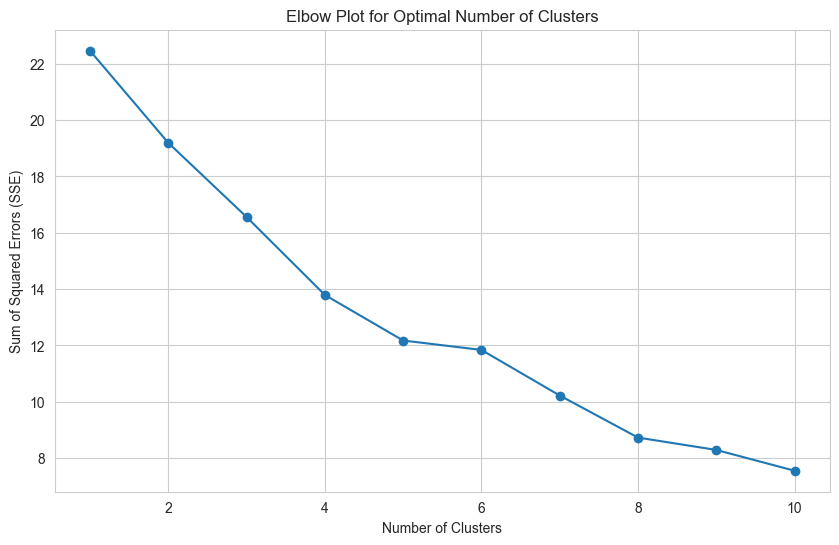

In [14]:
# Determine optimal number of clusters using elbow method
sse = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(daily_returns.T)
    sse.append(kmeans.inertia_)

# Plot elbow curve
plt.figure(figsize=(10, 6))
plt.plot(k_range, sse, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.title('Elbow Plot for Optimal Number of Clusters')
plt.grid(True)
plt.show()

In [15]:
# Perform clustering with optimal number of clusters
num_clusters = 8  # Based on elbow plot
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(daily_returns.T)

# Create DataFrame with cluster assignments
clustered_stocks = pd.DataFrame({
    'Ticker': daily_returns.columns,
    'Cluster': cluster_labels
})

print('\nClustered Stocks:')
print(clustered_stocks.sort_values('Cluster'))


Clustered Stocks:
   Ticker  Cluster
11     HD        0
20    NKE        0
24   SBUX        0
6       C        1
15    JPM        1
28    WFC        1
10     GS        1
4     BAC        1
27   TSLA        2
8     CVX        3
29    XOM        3
25    SLB        3
7     COP        3
5      BP        3
2     AMD        4
9   GOOGL        5
23   QCOM        5
0    AAPL        5
21   NVDA        5
13   INTC        5
3    AMZN        5
19   MSFT        5
1    ABBV        6
12    IBM        6
14    JNJ        6
22    PFE        6
18    MRK        6
16    MCD        6
26    TMO        6
17   META        7


<a id='optimization'></a>
## 5. Portfolio Optimization

Implement portfolio optimization with cluster constraints.

In [16]:
def portfolio_perf(weights, daily_returns, risk_free_rate=0.02):
    """
    Calculate portfolio performance metrics including Sortino ratio.
    
    Parameters:
    - weights: 1D array-like, portfolio weights (sum to 1)
    - daily_returns: 2D array-like, shape (n_days, n_assets) of daily returns
    - risk_free_rate: annual risk-free rate, e.g., 0.02 for 2%
    
    Returns:
    - portfolio_return: annualized portfolio return 
    - portfolio_volatility: annualized volatility 
    - sharpe_ratio: annualized Sharpe ratio 
    - sortino_ratio: annualized Sortino ratio 
    """
    
    # Compute the average daily return for each asset, then annualize it
    avg_daily_returns = np.mean(daily_returns, axis=0)  
    annualized_returns = avg_daily_returns * 252    
    
    # Compute daily returns covariance matrix
    cov_matrix = np.cov(daily_returns, rowvar=False)    

    # Annualized portfolio return = dot(annualized asset returns, weights).
    portfolio_return = np.dot(annualized_returns, weights) 

    # Annualize the covariance matrix and compute portfolio volatility
    annualized_cov_matrix = cov_matrix * 252
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(annualized_cov_matrix, weights)))

    # Sharpe ratio = (annual return - annual risk-free) / annual volatility
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility

    # Sortino ratio requires the distribution of daily portfolio returns.
    daily_portfolio_returns = np.dot(daily_returns, weights)

    # Convert annual risk-free to daily (simple linear approx)
    daily_rf = risk_free_rate / 252

    # Excess daily returns over daily RF
    excess_returns = daily_portfolio_returns - daily_rf

    # Take only negative excess returns (<= 0) for downside risk
    negative_excess = np.where(excess_returns < 0, excess_returns, 0.0)

    # Downside deviation (daily) = sqrt(mean(negative_excess^2))
    downside_deviation_daily = np.sqrt(np.mean(negative_excess ** 2))

    # Annualize the downside deviation: multiply by sqrt(252)
    annual_downside_deviation = downside_deviation_daily * np.sqrt(252)

    # Sortino ratio = (annual return - annual RF) / annualized downside stdev
    if annual_downside_deviation > 1e-12:
        sortino_ratio = (portfolio_return - risk_free_rate) / annual_downside_deviation
    else:
        sortino_ratio = np.nan
    
    return portfolio_return, portfolio_volatility, sharpe_ratio, sortino_ratio


def neg_sharpe(weights, daily_returns, risk_free_rate=0.02):
    """Negative Sharpe ratio for minimization."""
    return -portfolio_perf(weights, daily_returns, risk_free_rate)[2]

def neg_sortino(weights, daily_returns, risk_free_rate=0.02):
    """Negative Sortino ratio for minimization."""
    return -portfolio_perf(weights, daily_returns, risk_free_rate)[3]

def cluster_constraint(weights, cluster_labels, max_cluster_weight=0.4):
    """Ensure no cluster exceeds maximum weight."""
    for cluster in range(len(np.unique(cluster_labels))):
        cluster_mask = cluster_labels == cluster
        cluster_weight = np.sum(weights[cluster_mask])
        if cluster_weight > max_cluster_weight:
            return cluster_weight - max_cluster_weight
    return 0

def min_allocation_constraint(weights, min_allocation=0.01):
    """
    Ensure weights are either 0 or at least min_allocation.
    Returns a penalty value if constraint is violated.
    """
    # Find weights that are neither 0 (with small tolerance) nor >= min_allocation
    invalid_weights = np.where((weights > 1e-6) & (weights < min_allocation))[0]
    
    if len(invalid_weights) > 0:
        # Return sum of violations as penalty
        return np.sum(min_allocation - weights[invalid_weights])
    return 0

# Optimization constraints
constraints = [
    {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1},  # weights sum to 1
    {'type': 'ineq', 'fun': lambda weights: -cluster_constraint(weights, cluster_labels)},  # cluster constraint
    {'type': 'ineq', 'fun': lambda weights: -min_allocation_constraint(weights, min_allocation=0.01)}  # minimum allocation constraint
]

# Bounds for weights (0 to 25% per stock)
bounds = [(0, 0.25) for _ in range(len(stock_data.columns))]

# Initial guess (equal weights)
initial_weights = np.array([1.0 / len(stock_data.columns)] * len(stock_data.columns))

# Run Sharpe ratio optimization
sharpe_result = minimize(
    neg_sharpe,
    initial_weights,
    args=(daily_returns),
    method='SLSQP',
    bounds=bounds,
    constraints=constraints
)

# Run Sortino ratio optimization
sortino_result = minimize(
    neg_sortino,
    initial_weights,
    args=(daily_returns),
    method='SLSQP',
    bounds=bounds,
    constraints=constraints
)

# Get optimal weights
sharpe_optimal_weights = sharpe_result.x
sortino_optimal_weights = sortino_result.x

# Clean up very small weights to be exactly zero
sharpe_optimal_weights[sharpe_optimal_weights < 1e-4] = 0
sortino_optimal_weights[sortino_optimal_weights < 1e-4] = 0

# Re-normalize weights to ensure they sum to 1
sharpe_optimal_weights = sharpe_optimal_weights / np.sum(sharpe_optimal_weights)
sortino_optimal_weights = sortino_optimal_weights / np.sum(sortino_optimal_weights)

# Create DataFrame with optimal weights and cluster information
sharpe_optimal_portfolio = pd.DataFrame({
    'Ticker': stock_data.columns,
    'Weight': sharpe_optimal_weights,
    'Cluster': cluster_labels
})

sortino_optimal_portfolio = pd.DataFrame({
    'Ticker': stock_data.columns,
    'Weight': sortino_optimal_weights,
    'Cluster': cluster_labels
})

# Filter out stocks with zero weight
sharpe_optimal_portfolio = sharpe_optimal_portfolio[sharpe_optimal_portfolio['Weight'] > 0]
sortino_optimal_portfolio = sortino_optimal_portfolio[sortino_optimal_portfolio['Weight'] > 0]

# Calculate cluster weights
sharpe_cluster_weights = sharpe_optimal_portfolio.groupby('Cluster')['Weight'].sum()
sortino_cluster_weights = sortino_optimal_portfolio.groupby('Cluster')['Weight'].sum()

# Calculate portfolio performance metrics
sharpe_portfolio_return, sharpe_portfolio_volatility, sharpe_sharpe_ratio, sharpe_sortino_ratio = portfolio_perf(sharpe_optimal_weights, daily_returns)
sortino_portfolio_return, sortino_portfolio_volatility, sortino_sharpe_ratio, sortino_sortino_ratio = portfolio_perf(sortino_optimal_weights, daily_returns)

# Display sharpe optimal portfolio weights and performance metrics in a table
print('\nSharpe Ratio Optimal Portfolio Weights and Performance Metrics:')
print(sharpe_optimal_portfolio.sort_values('Weight', ascending=False).head())
print(f'\nPortfolio Return: {sharpe_portfolio_return:.2%}')
print(f'Portfolio Volatility: {sharpe_portfolio_volatility:.2%}')  
print(f'Sharpe Ratio: {sharpe_sharpe_ratio:.2f}')
print(f'Sortino Ratio: {sharpe_sortino_ratio:.2f}')
print(f'Number of Stocks in Portfolio: {len(sharpe_optimal_portfolio)}')

# Display sharpe optimal portfolio cluster weights
print('\nCluster Weights:')
print(sharpe_cluster_weights)

# Display sortino optimal portfolio weights and performance metrics in a table
print('\nSortino Ratio Optimal Portfolio Weights and Performance Metrics:')
print(sortino_optimal_portfolio.sort_values('Weight', ascending=False).head())
print(f'\nPortfolio Return: {sortino_portfolio_return:.2%}')
print(f'Portfolio Volatility: {sortino_portfolio_volatility:.2%}')
print(f'Sharpe Ratio: {sortino_sharpe_ratio:.2f}')
print(f'Sortino Ratio: {sortino_sortino_ratio:.2f}')
print(f'Number of Stocks in Portfolio: {len(sortino_optimal_portfolio)}')

# Display sortino optimal portfolio cluster weights
print('\nCluster Weights:')
print(sortino_cluster_weights)


Sharpe Ratio Optimal Portfolio Weights and Performance Metrics:
   Ticker  Weight  Cluster
21   NVDA  0.2500        5
1    ABBV  0.2500        6
16    MCD  0.1831        6
0    AAPL  0.1205        5
27   TSLA  0.0784        2

Portfolio Return: 32.23%
Portfolio Volatility: 22.28%
Sharpe Ratio: 1.36
Sortino Ratio: 1.97
Number of Stocks in Portfolio: 10

Cluster Weights:
Cluster
0    0.0100
1    0.0239
2    0.0784
5    0.4000
6    0.4771
7    0.0107
Name: Weight, dtype: float64

Sortino Ratio Optimal Portfolio Weights and Performance Metrics:
   Ticker  Weight  Cluster
21   NVDA  0.2500        5
1    ABBV  0.2131        6
16    MCD  0.1911        6
0    AAPL  0.1140        5
18    MRK  0.0814        6

Portfolio Return: 32.42%
Portfolio Volatility: 22.42%
Sharpe Ratio: 1.36
Sortino Ratio: 1.98
Number of Stocks in Portfolio: 10

Cluster Weights:
Cluster
1    0.0117
2    0.0732
4    0.0295
5    0.4000
6    0.4857
Name: Weight, dtype: float64


In [17]:
# Filter expected returns DataFrame for assets in either of the optimal portfolios
optimal_portfolio_assets = pd.concat([sharpe_optimal_portfolio, sortino_optimal_portfolio]).drop_duplicates(subset=['Ticker']).reset_index(drop=True)
filtered_stock_data = stock_data[optimal_portfolio_assets['Ticker'].values]

# Calculate daily returns for filtered assets
filtered_daily_returns = filtered_stock_data.pct_change().dropna()

filtered_returns = filtered_daily_returns.mean() 
filtered_cov = filtered_daily_returns.cov() 

<a id='simulation'></a>
## 6. Monte Carlo Simulation

Run Monte Carlo simulation to visualize the efficient frontier.

In [21]:
# Monte Carlo Simulation with Improved Portfolio Generation
num_portfolios = 10000
results = np.zeros((4, num_portfolios))  # 4 metrics: volatility, return, Sharpe, Sortino

weights_record = []  # Record the weights of each portfolio

np.random.seed(42)  # For reproducibility

# First, generate all the portfolios
for i in range(num_portfolios):  # Generate 10000 portfolios
    # Generate diverse weights for the filtered assets
    weights = np.random.random(len(filtered_stock_data.columns))
    weights /= np.sum(weights)  # Normalize to sum to 1
    weights_record.append(weights)

    # Calculate portfolio performance
    port_return, port_vol, sharpe_ratio, sortino_ratio = portfolio_perf(weights, filtered_daily_returns.values, risk_free_rate=0.02)
    
    # Add the portfolio to our results
    results[:, i] = [port_vol, port_return, sharpe_ratio, sortino_ratio]

# Convert to numpy array for more efficient processing
weights_record = np.array(weights_record)

# Create DataFrame from results
results_df = pd.DataFrame({
    'Volatility': results[0, :],
    'Return': results[1, :],
    'Sharpe': results[2, :],
    'Sortino': results[3, :]
})

# Verify the data in the DataFrame
print("Random Simulated Portfolios Statistics:")
print(results_df.describe())

Random Simulated Portfolios Statistics:
       Volatility      Return      Sharpe     Sortino
count  10000.0000  10000.0000  10000.0000  10000.0000
mean       0.2235      0.2842      1.1810      1.6907
std        0.0169      0.0246      0.0472      0.0720
min        0.1745      0.2053      1.0079      1.4348
25%        0.2119      0.2670      1.1453      1.6358
50%        0.2227      0.2841      1.1856      1.6970
75%        0.2341      0.3007      1.2171      1.7465
max        0.3174      0.4100      1.3226      1.9185


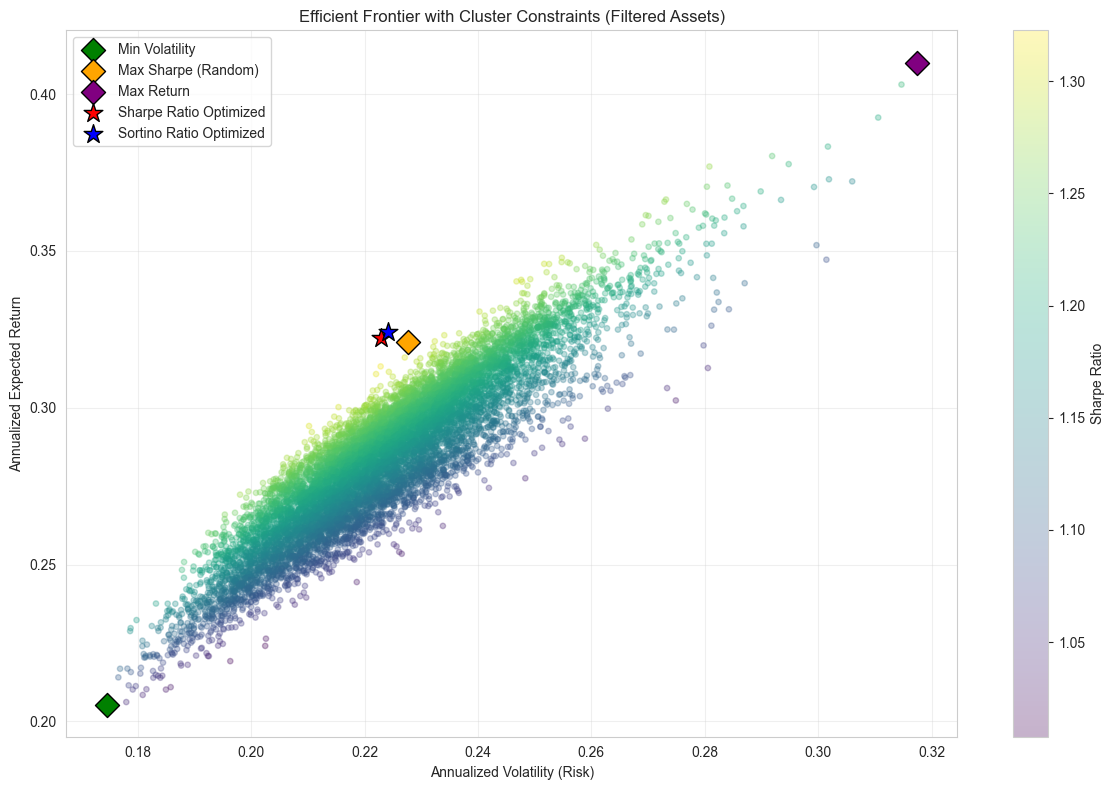


Optimized Portfolio Performance:
Sharpe Ratio Optimized: Return = 0.3223, Volatility = 0.2228, Sharpe = 1.3564
Sortino Ratio Optimized: Return = 0.3242, Volatility = 0.2242, Sharpe = 1.3569


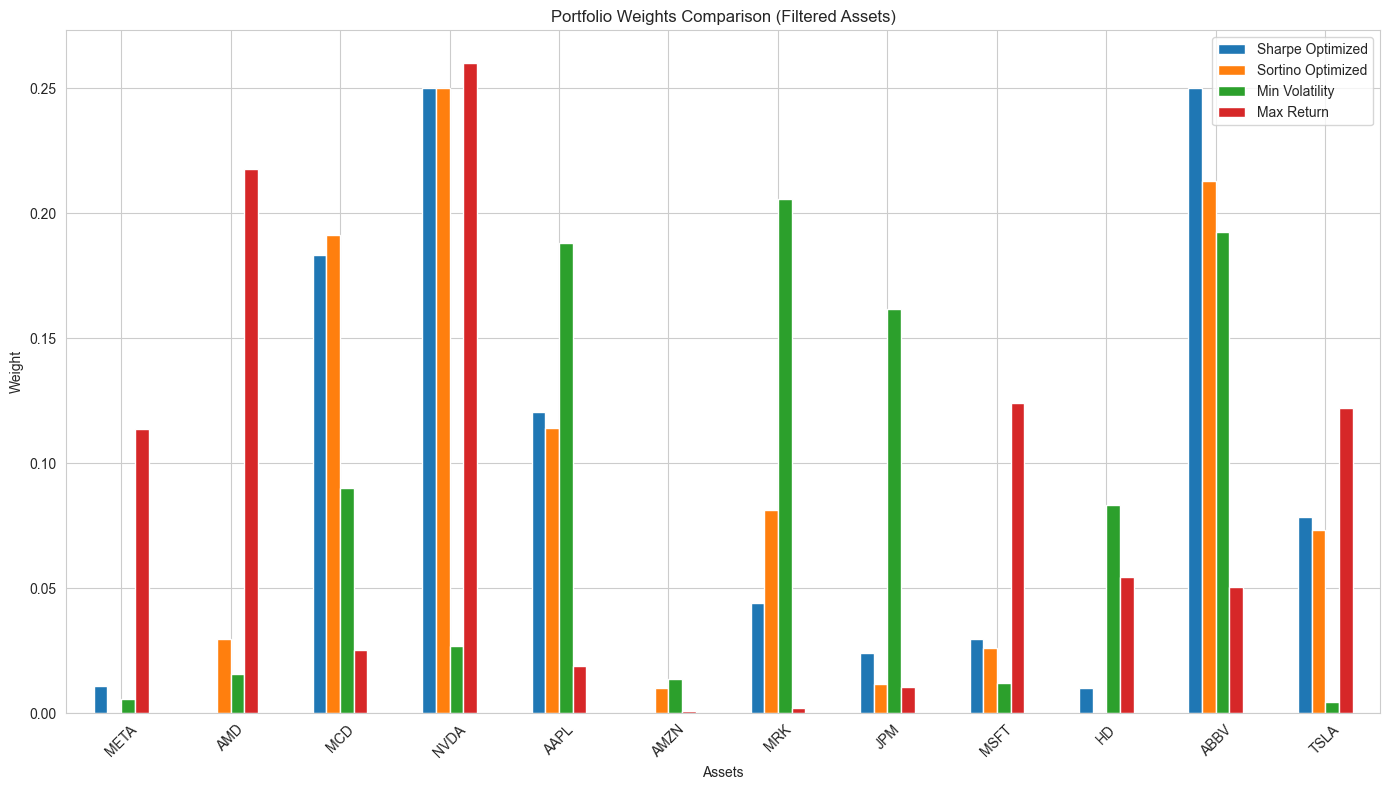

In [22]:
# Plot efficient frontier
plt.figure(figsize=(12, 8))

# Plot ALL portfolios as scatter points
plt.scatter(results_df['Volatility'], results_df['Return'], 
           c=results_df['Sharpe'], cmap='viridis', alpha=0.3, s=15)
plt.colorbar(label='Sharpe Ratio')

# Calculate min vol, max sharpe, and max return portfolios
min_vol_idx = results_df['Volatility'].idxmin()
max_sharpe_idx = results_df['Sharpe'].idxmax()
max_return_idx = results_df['Return'].idxmax()

# Plot special portfolios from Monte Carlo simulation
plt.scatter(results_df.loc[min_vol_idx, 'Volatility'], 
            results_df.loc[min_vol_idx, 'Return'], 
            c='green', marker='D', s=150, label='Min Volatility', edgecolors='black')
            
plt.scatter(results_df.loc[max_sharpe_idx, 'Volatility'], 
            results_df.loc[max_sharpe_idx, 'Return'], 
            c='orange', marker='D', s=150, label='Max Sharpe (Random)', edgecolors='black')

plt.scatter(results_df.loc[max_return_idx, 'Volatility'], 
            results_df.loc[max_return_idx, 'Return'], 
            c='purple', marker='D', s=150, label='Max Return', edgecolors='black')

# Plot optimized portfolios
plt.scatter(sharpe_portfolio_volatility, sharpe_portfolio_return, c='red', marker='*', s=200, 
           label='Sharpe Ratio Optimized', edgecolors='black')

plt.scatter(sortino_portfolio_volatility, sortino_portfolio_return, c='blue', marker='*', s=200, 
           label='Sortino Ratio Optimized', edgecolors='black')

# Add labels and formatting
plt.xlabel('Annualized Volatility (Risk)')
plt.ylabel('Annualized Expected Return')
plt.title('Efficient Frontier with Cluster Constraints (Filtered Assets)')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)

# Force the plot to show all points
plt.tight_layout()
plt.show()

# Print performance metrics for optimized portfolios
print("\nOptimized Portfolio Performance:")
print(f"Sharpe Ratio Optimized: Return = {sharpe_portfolio_return:.4f}, Volatility = {sharpe_portfolio_volatility:.4f}, Sharpe = {sharpe_sharpe_ratio:.4f}")
print(f"Sortino Ratio Optimized: Return = {sortino_portfolio_return:.4f}, Volatility = {sortino_portfolio_volatility:.4f}, Sharpe = {sortino_sharpe_ratio:.4f}")

# Extract tickers from filtered stock data
filtered_tickers = filtered_stock_data.columns.tolist()

# Get the tickers from the optimal portfolios
sharpe_tickers = sharpe_optimal_portfolio['Ticker'].tolist()
sortino_tickers = sortino_optimal_portfolio['Ticker'].tolist()

# Extract the optimal weights for each portfolio
sharpe_opt_weights = pd.Series(sharpe_optimal_portfolio['Weight'].values, index=sharpe_optimal_portfolio['Ticker'])
sortino_opt_weights = pd.Series(sortino_optimal_portfolio['Weight'].values, index=sortino_optimal_portfolio['Ticker'])

# Get the weights from the Monte Carlo simulation
min_vol_weights = pd.Series(weights_record[min_vol_idx], index=filtered_tickers)
max_return_weights = pd.Series(weights_record[max_return_idx], index=filtered_tickers)

# Create a DataFrame for portfolio weights with all possible tickers
all_tickers = list(set(sharpe_tickers + sortino_tickers + filtered_tickers))
weight_comparison = pd.DataFrame(index=all_tickers)

# Add each portfolio's weights
weight_comparison['Sharpe Optimized'] = sharpe_opt_weights
weight_comparison['Sortino Optimized'] = sortino_opt_weights
weight_comparison['Min Volatility'] = min_vol_weights
weight_comparison['Max Return'] = max_return_weights

# Fill NaN values with 0
weight_comparison = weight_comparison.fillna(0)

# Display weight comparison
weight_comparison.plot(kind='bar', figsize=(14, 8))
plt.title('Portfolio Weights Comparison (Filtered Assets)')
plt.xlabel('Assets')
plt.ylabel('Weight')
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.tight_layout()
plt.show()

<a id='results'></a>
## 7. Results Analysis

Analyze and summarize the optimization results.


Sharpe Optimal Portfolio Performance:
Expected Annual Return: 32.23%
Annualized Volatility: 22.28%
Sharpe Ratio: 1.17

Sortino Optimal Portfolio Performance:
Expected Annual Return: 32.42%
Annualized Volatility: 22.42%
Sortino Ratio: 1.65

Sharpe Optimal Portfolio Sector Exposure:
Sector
Consumer      0.2715
Financials    0.0239
Healthcare    0.2940
Technology    0.4107
Name: Weight, dtype: float64

Sortino Optimal Portfolio Sector Exposure:
Sector
Consumer      0.2643
Financials    0.0117
Healthcare    0.2945
Technology    0.4295
Name: Weight, dtype: float64


<Figure size 1200x600 with 0 Axes>

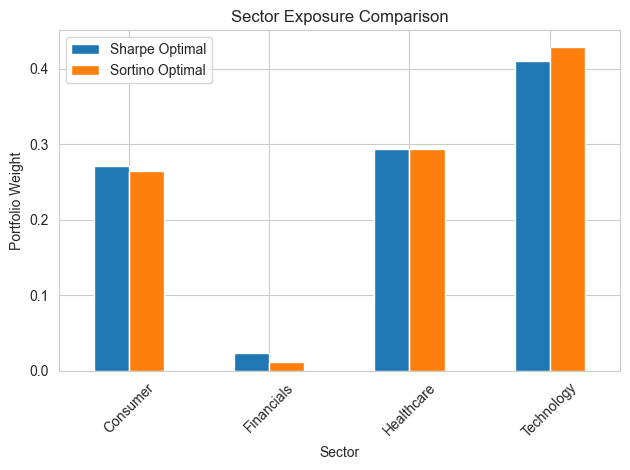

In [20]:
print('\nSharpe Optimal Portfolio Performance:')
print(f'Expected Annual Return: {sharpe_portfolio_return:.2%}')
print(f'Annualized Volatility: {sharpe_portfolio_volatility:.2%}')
print(f'Sharpe Ratio: {sharpe_ratio:.2f}')

print('\nSortino Optimal Portfolio Performance:')
print(f'Expected Annual Return: {sortino_portfolio_return:.2%}')
print(f'Annualized Volatility: {sortino_portfolio_volatility:.2%}')
print(f'Sortino Ratio: {sortino_ratio:.2f}')

# Analyze sector exposure for Sharpe optimal portfolio
sharpe_sector_exposure = pd.DataFrame({
    'Sector': [sector for sector, stocks in tickers.items() for stock in stocks if stock in sharpe_tickers],
    'Weight': [sharpe_opt_weights[stock] for sector, stocks in tickers.items() for stock in stocks if stock in sharpe_tickers]
}).groupby('Sector')['Weight'].sum()

# Analyze sector exposure for Sortino optimal portfolio
sortino_sector_exposure = pd.DataFrame({
    'Sector': [sector for sector, stocks in tickers.items() for stock in stocks if stock in sortino_tickers],
    'Weight': [sortino_opt_weights[stock] for sector, stocks in tickers.items() for stock in stocks if stock in sortino_tickers]
}).groupby('Sector')['Weight'].sum()

print('\nSharpe Optimal Portfolio Sector Exposure:')
print(sharpe_sector_exposure.round(4))

print('\nSortino Optimal Portfolio Sector Exposure:')
print(sortino_sector_exposure.round(4))

# Plot sector exposure for both portfolios
plt.figure(figsize=(12, 6))
sector_comparison = pd.DataFrame({
    'Sharpe Optimal': sharpe_sector_exposure,
    'Sortino Optimal': sortino_sector_exposure
}).fillna(0)

sector_comparison.plot(kind='bar')
plt.title('Sector Exposure Comparison')
plt.xlabel('Sector')
plt.ylabel('Portfolio Weight')
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.tight_layout()
plt.show()